In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#downloading stock data from 2010 to 2023
#i selected this range becouse it is good range with enough history
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-12-31')

[*********************100%***********************]  1 of 1 completed


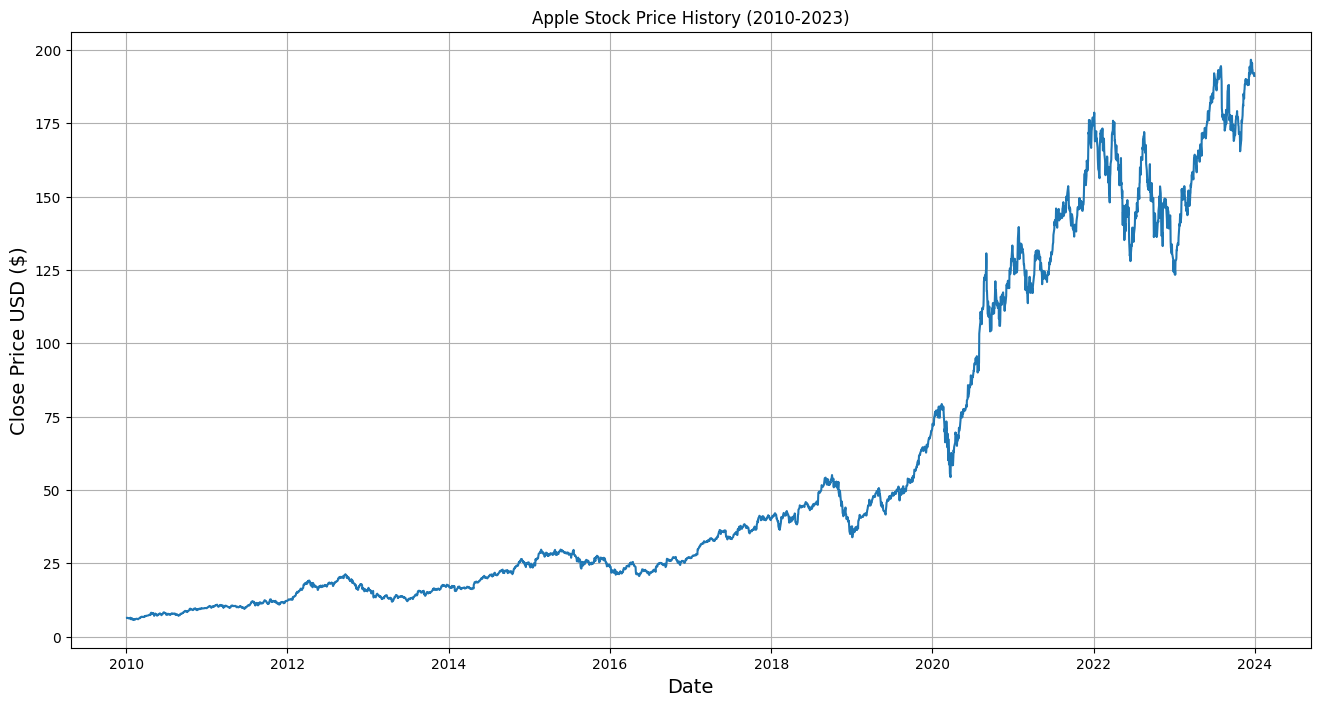

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Apple Stock Price History (2010-2023)')
plt.plot(stock_data['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
#We wil use only close price for prediction
data  = stock_data['Close']
dataset = data.values.reshape(-1,1) #converts it from a 1D array to a 2D array with 1 column.
#Reason LSTM models require 2D or 3D input—this step is part of preparing the data.

The 'Close' price is the final price of the stock each day and is commonly used to analyze trends and make predictions.

I am ignoring other columns like 'Open', 'High', 'Low', and 'Volume' to simplify the model.



In [ ]:
# Scale the data between 0 and 1 (LSTMs work better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

##Why scal the data
LSTM model perform better with normalized data.

without scaling, large values (like 300 or 400 stock prices) could dominate and make t hard for the model to learn

scaling speeds up traning, improves accuracy, and  helps with gradient based learning



> scaled_data is a 2D array where all values are between 0 and 1.

> Now it's ready to be split into sequences and used in your LSTM model.



In [ ]:
# create traning dataset(80% of data)
traning_data_len = int(np.ceil(len(dataset)*0.8))

#create  scaled traning data
train_data = scaled_data[0:traning_data_len, :]

In [ ]:
#split into x_train and y_train datasets
def create_dataset(dataset, time_step=60): # the model learns to predict the next value based on the last time_step (60) values.
  x, y = [], []
  for i in range(time_step, len(dataset)):
    x.append(dataset[i-time_step:i, 0])
    y.append(dataset[i, 0])
  return np.array(x), np.array(y)

time_step = 60
x_train, y_train = create_dataset(train_data, time_step)

In [ ]:
#reshape the data for LSTM (sample, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #used to reshape the training input data to the format required by LSTM models in Keras/TensorFlow.

###builds and trains our LSTM model for stock price prediction.

In [ ]:
model = Sequential() #Starts a blank model — we will stack layers on it
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))#Adds an LSTM layer with 50 units (neurons)
model.add(Dropout(0.2)) #Prevents overfitting by randomly turning off 20% of neurons during training.
model.add(LSTM(50, return_sequences=False)) #Another LSTM with 50 units and only returns final output (used before Dense layers)
model.add(Dropout(0.2)) #Again, helps reduce overfitting
model.add(Dense(25)) #Dense(25): A hidden layer with 25 neurons
model.add(Dense(1)) # Dense(1): Final output layer — predicting 1 value (next day’s stock price)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') #adam: Optimizer (automatically adjusts learning rate)

'''mean_squared_error: Suitable for regression (minimizes the difference between predicted and actual prices)'''

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=10) #Updates weights after every 32 samples #Goes through the entire dataset 10 times

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0065
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 7.0905e-04
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.1088e-04
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 4.4871e-04
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 2.9520e-04
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 3.1889e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 3.9822e-04
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 2.8674e-04
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 2.5256e-04
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.6782e-04


We have now:

Built a 2-layer LSTM model

Compiled it with Adam optimizer and MSE loss

Trained it on our past 60-day sequences to predict next day prices

In [ ]:
# Create the testing dataset
test_data = scaled_data[training_data_len - time_step:, :]
x_test, y_test = create_dataset(test_data, time_step)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2))
print(f"Root Mean Squared Error: {rmse}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Root Mean Squared Error: 5.412374626681074


In [ ]:
# Plot predictions vs actual
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()
valid['Predictions'] = predictions

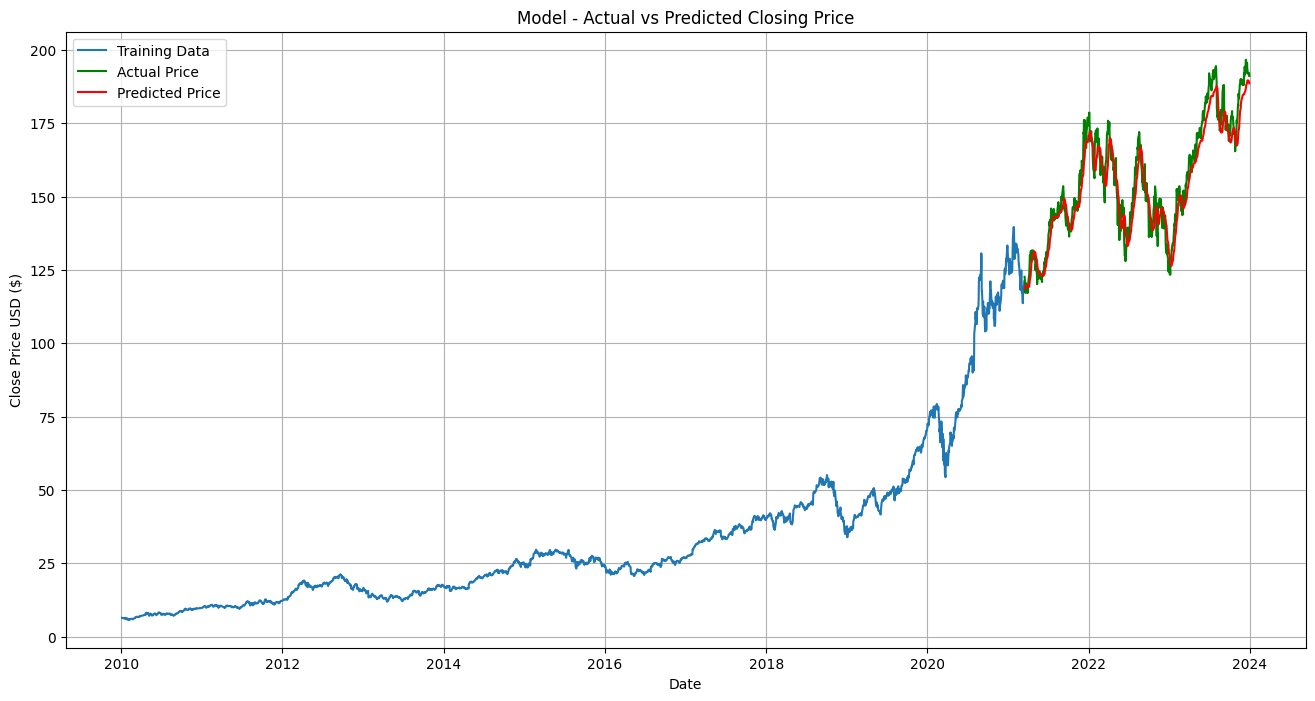

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Model - Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train, label='Training Data')
plt.plot(valid['AAPL'], label='Actual Price', color='green')
plt.plot(valid['Predictions'], label='Predicted Price', color='red')
plt.legend()
plt.grid(True)
plt.show()

Data Used: Apple (AAPL) stock prices from 2010 to 2023

Model Type: 2-layer LSTM with dropout

Feature Used: Only 'Close' price

Time Steps: 60 days

Epochs: 10

RMSE: 5.41 (Good accuracy)

Prediction Quality: Visually accurate, follows real trend closely

Charts: Show clear match between actual and predicted prices